In [1]:
from hestonpy.models.heston import Heston
from hestonpy.models.bates import Bates
from hestonpy.models.calibration.volatilitySmile import VolatilitySmile

r = 0.00

# Calibration on market data

Get market data

In [2]:
from hestonpy.option.data import get_options_data, filter_data_for_maturity
symbol='^SPX'
all_market_data, spot, maturities = get_options_data(symbol=symbol)
spot

np.float64(5664.0498046875)

Choose your smile/maturity

In [3]:
maturities

('2025-04-02',
 '2025-04-03',
 '2025-04-04',
 '2025-04-07',
 '2025-04-08',
 '2025-04-09',
 '2025-04-10',
 '2025-04-11',
 '2025-04-14',
 '2025-04-15',
 '2025-04-16',
 '2025-04-17',
 '2025-04-21',
 '2025-04-22',
 '2025-04-23',
 '2025-04-24',
 '2025-04-25',
 '2025-04-28',
 '2025-04-29',
 '2025-04-30',
 '2025-05-01',
 '2025-05-02',
 '2025-05-05',
 '2025-05-06',
 '2025-05-08',
 '2025-05-09',
 '2025-05-16',
 '2025-05-30',
 '2025-06-20',
 '2025-06-30',
 '2025-07-18',
 '2025-07-31',
 '2025-08-15',
 '2025-08-29',
 '2025-09-19',
 '2025-09-30',
 '2025-10-17',
 '2025-11-21',
 '2025-12-19',
 '2025-12-31',
 '2026-01-16',
 '2026-02-20',
 '2026-03-20',
 '2026-03-31',
 '2026-04-17',
 '2026-06-18',
 '2026-12-18',
 '2027-12-17',
 '2028-12-15',
 '2029-12-21',
 '2030-12-20')

In [4]:
maturity = maturities[28]
full_market_data = filter_data_for_maturity(all_market_data, maturity)
full_market_data.head()

,Call Price,Bid,Ask,Implied Volatility,Strike,Volume,Time to Maturity,Maturity
0,5495.40,5423.4,5439.2,0.00001,200.0,2.0,0.22619,2025-06-20
1,5208.01,5219.9,5238.0,0.00001,400.0,1.0,0.22619,2025-06-20
2,5010.16,5021.5,5039.6,0.00001,600.0,1.0,0.22619,2025-06-20
3,4820.39,4823.9,4842.0,0.00001,800.0,6.0,0.22619,2025-06-20
4,4608.28,4626.4,4644.1,0.00001,1000.0,2.0,0.22619,2025-06-20


Sanity check of the data from yfinance

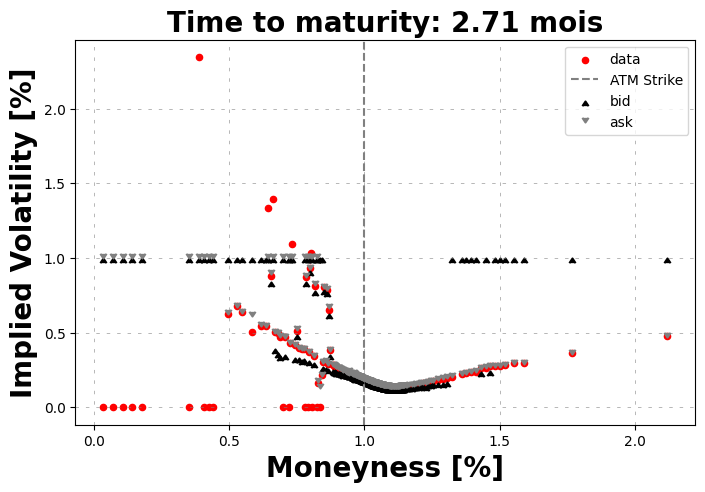

In [5]:
time_to_maturity = full_market_data['Time to Maturity'].iloc[0]
strikes = full_market_data['Strike'].values
bid_prices = full_market_data["Bid"].values
ask_prices = full_market_data['Ask'].values
market_ivs = full_market_data['Implied Volatility'].values
market_prices = full_market_data['Call Price'].values

marketVolatilitySmile = VolatilitySmile(
    strikes=strikes,
    time_to_maturity=time_to_maturity,
    atm=spot,
    market_ivs=market_ivs,
    r=r
)
marketVolatilitySmile.plot(bid_prices=bid_prices, ask_prices=ask_prices)

Hmmm it is ugly, run some filters and use the mid implied volatility to denoise the market, $$\frac{\sigma_{bid}+\sigma_{ask}}{2}$$

In [6]:
market_data = marketVolatilitySmile.filters(full_market_data)
marketVolatilitySmile.plot()
market_data.head()

KeyboardInterrupt: 

We can now calibrate an Heston model and an Bates model on the cleaned data

## Calibration with an Heston model

Calibrated parameters: v0=0.036 | kappa=9.763 | theta=0.063 | sigma=1.832 | rho=-0.807

at minimum 0.023551 accepted 1
Parameters: kappa=9.763 | theta=0.063 | sigma=1.832 | rho=-0.806 

at minimum 0.023571 accepted 1
Parameters: kappa=9.894 | theta=0.063 | sigma=1.848 | rho=-0.806 

at minimum 0.023614 accepted 1
Parameters: kappa=9.919 | theta=0.063 | sigma=1.854 | rho=-0.806 

at minimum 0.023563 accepted 1
Parameters: kappa=9.898 | theta=0.063 | sigma=1.849 | rho=-0.806 

at minimum 0.023532 accepted 1
Parameters: kappa=9.870 | theta=0.063 | sigma=1.846 | rho=-0.806 

at minimum 0.023557 accepted 1
Parameters: kappa=9.895 | theta=0.063 | sigma=1.849 | rho=-0.806 

at minimum 0.024002 accepted 1
Parameters: kappa=9.088 | theta=0.064 | sigma=1.759 | rho=-0.807 

at minimum 0.023537 accepted 1
Parameters: kappa=9.880 | theta=0.063 | sigma=1.847 | rho=-0.806 

['success condition satisfied'] True
Calibrated parameters: v0=0.036 | kappa=9.870 | theta=0.063 | sigma=1.846 | rho=-0.806



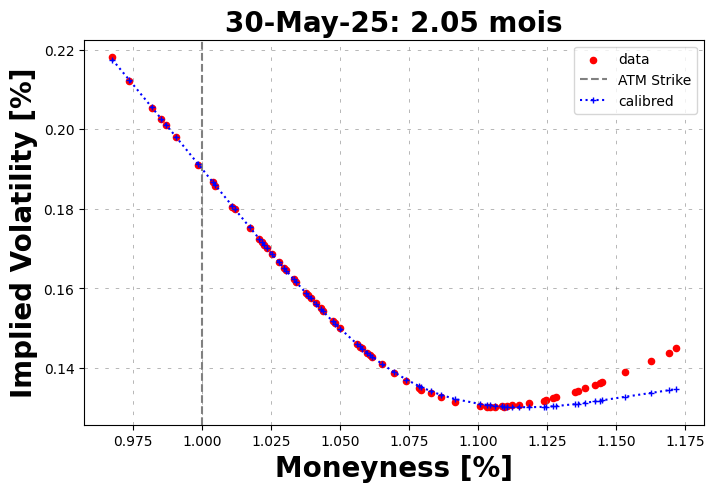

{'vol_initial': np.float64(0.03646176147871301),
 'kappa': np.float64(9.869725719029796),
 'theta': np.float64(0.06333193499610625),
 'sigma': np.float64(1.8457229965916433),
 'rho': np.float64(-0.8061467404885212),
 'drift_emm': 0}

In [ ]:
params = {
    "kappa": 1.25,
    "theta": 0.06,
    "sigma": 0.6,
    "rho": -0.8,
}
heston = Heston(spot=spot, vol_initial=0.06, r=r, drift_emm=0, **params)

initial_params = marketVolatilitySmile.calibration(
    price_function=heston.call_price,
    guess_correlation_sign='negative',
    initial_guess=list(params.values()),
    speed='local',
)

initial_guess = [initial_params['kappa'], initial_params['theta'], initial_params['sigma'], initial_params['rho']]
calibrated_params = marketVolatilitySmile.calibration(
    price_function=heston.call_price,
    guess_correlation_sign='negative',
    initial_guess=initial_guess,
    power='mse',
    speed='global',
)

marketVolatilitySmile.plot(
    calibrated_prices=heston.call_price(strike=marketVolatilitySmile.strikes, time_to_maturity=time_to_maturity, **calibrated_params),
    maturity=maturity
)
calibrated_params

## Calibration with a Baites model

In [ ]:
calibrated_params

{'vol_initial': np.float64(0.03418126258045936),
 'kappa': np.float64(1.6524307981357256),
 'theta': np.float64(0.001),
 'drift_emm': 0,
 'sigma': np.float64(0.4948309329882636),
 'rho': np.float64(-0.7498716551238577),
 'lambda_jump': np.float64(0.1167875695521678),
 'mu_J': np.float64(-0.5),
 'sigma_J': np.float64(0.3473307538042298)}

Calibrated parameters:
 v0=0.034 | kappa=1.652 | theta=0.001 | sigma=0.495 | rho=-0.750  | lambda_jump=0.117  | mu_J=-0.500  | sigma_J=0.050

at minimum nan accepted 1
Parameters: kappa=1.652 | theta=0.001 | sigma=0.495 | rho=-0.750  | lambda_jump=0.117  | mu_J=-0.500  | sigma_J=0.050 

at minimum 0.732971 accepted 1
Parameters: kappa=1.652 | theta=0.001 | sigma=0.495 | rho=-0.750  | lambda_jump=0.117  | mu_J=-0.500  | sigma_J=0.347 

at minimum 0.732971 accepted 1
Parameters: kappa=1.652 | theta=0.001 | sigma=0.495 | rho=-0.750  | lambda_jump=0.117  | mu_J=-0.500  | sigma_J=0.347 

at minimum 0.734213 accepted 1
Parameters: kappa=1.758 | theta=0.003 | sigma=0.499 | rho=-0.751  | lambda_jump=0.117  | mu_J=-0.500  | sigma_J=0.349 

at minimum 0.732971 accepted 1
Parameters: kappa=1.652 | theta=0.001 | sigma=0.495 | rho=-0.750  | lambda_jump=0.117  | mu_J=-0.500  | sigma_J=0.347 

['success condition satisfied'] True
Calibrated parameters:
 v0=0.034 | kappa=1.652 | theta=0.001 | sigma=0.

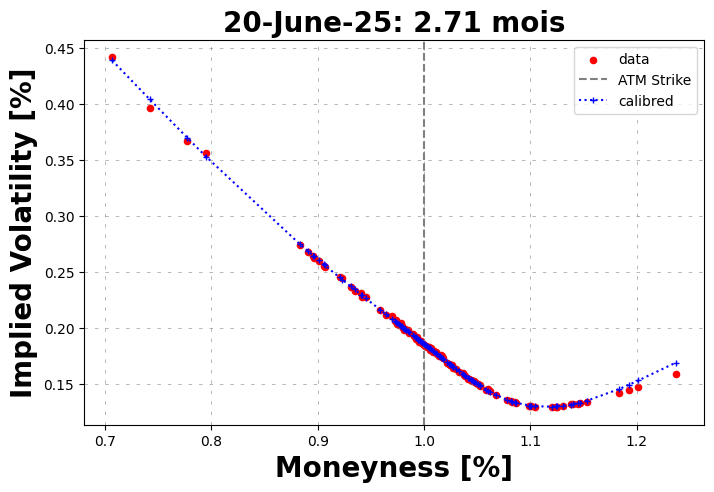

{'vol_initial': np.float64(0.03418126258045936),
 'kappa': np.float64(1.6524340301076816),
 'theta': np.float64(0.001),
 'drift_emm': 0,
 'sigma': np.float64(0.49483092969382403),
 'rho': np.float64(-0.7498713974833794),
 'lambda_jump': np.float64(0.11678766889964226),
 'mu_J': np.float64(-0.5),
 'sigma_J': np.float64(0.34733044904436533)}

In [ ]:
params = {
    "kappa": 1.25,
    "theta": 0.06,
    "sigma": 0.6,
    "rho": -0.5,
    "lambda_jump": 1.0,
    "mu_J": -0.1,
    'sigma_J': 0.3 
}

params = {
    "kappa": calibrated_params["kappa"],
    "theta": calibrated_params["theta"],
    "sigma": calibrated_params["sigma"],
    "rho": calibrated_params["rho"],
    "lambda_jump": calibrated_params["lambda_jump"],
    "mu_J": calibrated_params["mu_J"],
    'sigma_J': calibrated_params['sigma_J']
}


bates = Bates(spot=spot, vol_initial=0.06, r=r, drift_emm=0, **params)

initial_params = marketVolatilitySmile.calibration(
    price_function=bates.call_price,
    guess_correlation_sign='negative',
    initial_guess=list(params.values()),
    power='mse',
    speed='local',
)

initial_guess = [initial_params['kappa'], initial_params['theta'], initial_params['sigma'], initial_params['rho'], 
                 initial_params['lambda_jump'], initial_params['mu_J'], initial_params['sigma_J']]
calibrated_params = marketVolatilitySmile.calibration(
    price_function=bates.call_price,
    guess_correlation_sign='negative',
    initial_guess=initial_guess,
    power='mse',
    speed='global',
)

marketVolatilitySmile.plot(
    calibrated_prices=bates.call_price(strike=marketVolatilitySmile.strikes, time_to_maturity=time_to_maturity, **calibrated_params),
    maturity=maturity
)
calibrated_params

Fancy plot

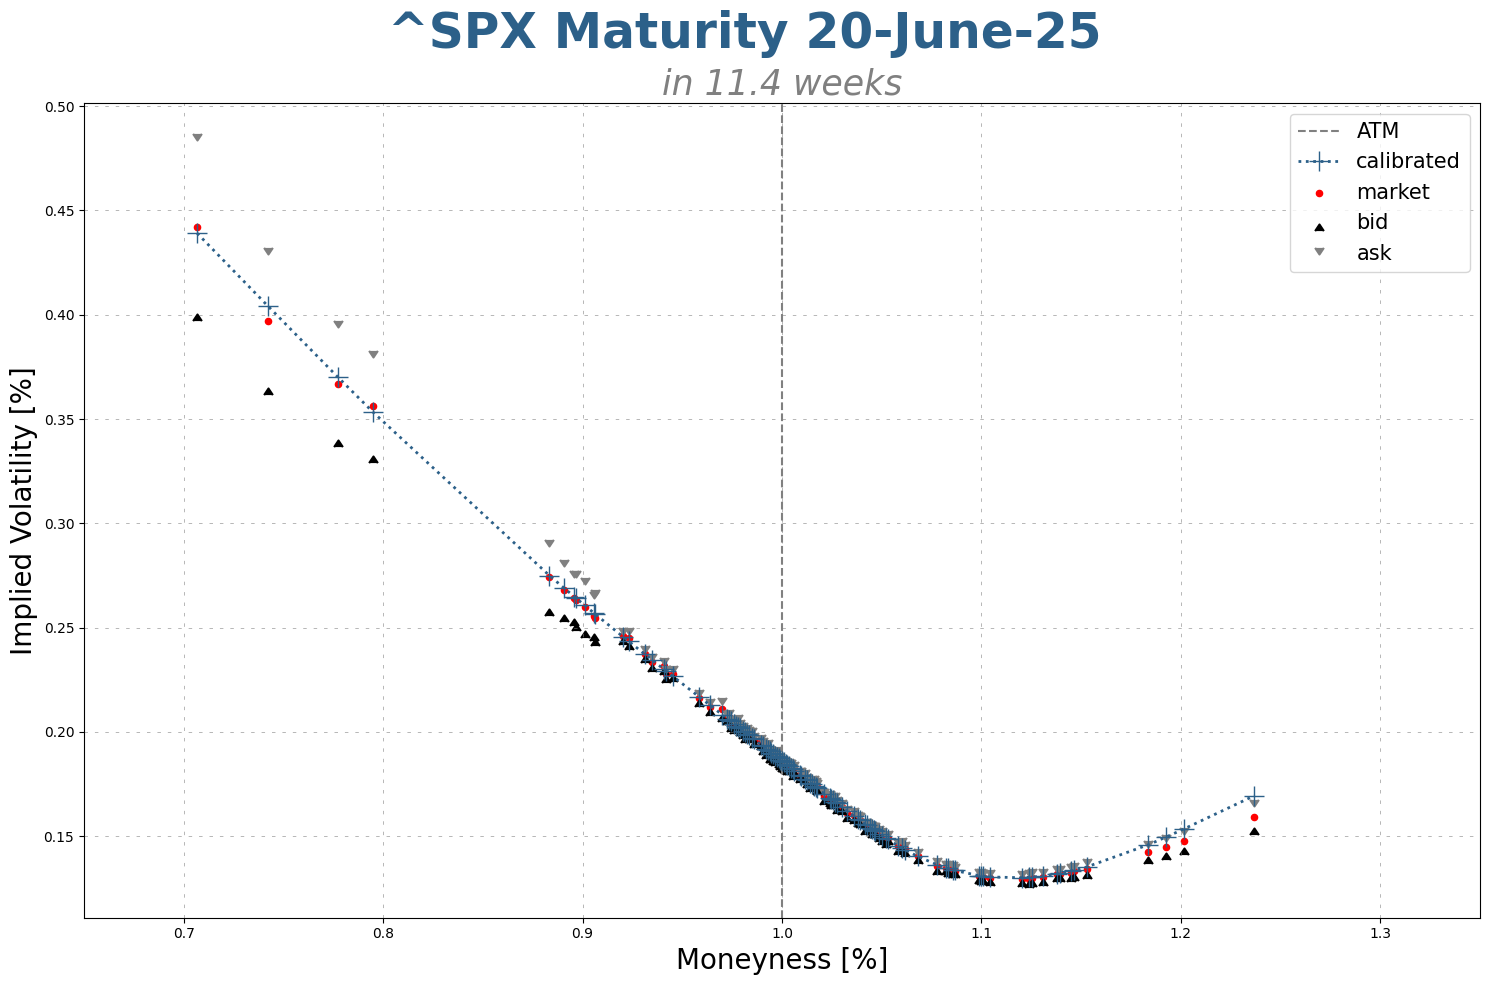

In [ ]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
font_legend = font_manager.FontProperties(
    style='normal', 
    size=20,
)
fontdict = {
    "fontsize": 20, 
    # "fontweight": "bold"
}
fontdict_suptitle = {
    'fontsize': 30,
    'fontweight': 'bold'
    }
fontdict_title = {
    'fontsize': 30,
    'fontweight': 'bold'
    }

calibrated_prices = bates.call_price(strike=marketVolatilitySmile.strikes, time_to_maturity=time_to_maturity, **calibrated_params)
calibrated_ivs = marketVolatilitySmile.compute_smile(prices=calibrated_prices)
ask_ivs = market_data['Ask ivs'].values
bid_ivs = market_data['Bid ivs'].values
forward = marketVolatilitySmile.atm * np.exp(marketVolatilitySmile.r * marketVolatilitySmile.time_to_maturity)

plt.figure(figsize=(15, 10))
plt.axvline(1, linestyle="--", color="gray", label='ATM')
plt.plot(marketVolatilitySmile.strikes / forward, calibrated_ivs, marker='+', color='#2c6089', linestyle="dotted", markersize=14, linewidth=2, label='calibrated')
plt.scatter(marketVolatilitySmile.strikes / forward, marketVolatilitySmile.market_ivs, marker='o', color='red', s=20, label='market')
plt.scatter(marketVolatilitySmile.strikes / forward, bid_ivs, marker=6, color='black', s=40, label='bid')
plt.scatter(marketVolatilitySmile.strikes / forward, ask_ivs, marker=7, color='gray', s=40, label='ask')

plt.xlabel("Moneyness [%]", fontdict=fontdict)
plt.ylabel("Implied Volatility [%]", fontdict=fontdict)
plt.xlim((0.65, 1.35))

date = datetime.strptime(maturity, '%Y-%m-%d').date().strftime("%d-%B-%y")
title = f"{symbol} Maturity {date}"
plt.suptitle(title, fontsize=35, fontweight='bold', color='#2c6089')
plt.title(f"in {marketVolatilitySmile.time_to_maturity * 252 / 5:.1f} weeks", color="grey", style='italic', fontsize=25)

plt.grid(visible=True, which="major", linestyle="--", dashes=(5, 10), color="gray", linewidth=0.5, alpha=0.8)
plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig("smile-bates.png")
plt.show()